# Out of core dataframes for Python
## PyParis 2018

In [1]:
import warnings
warnings.simplefilter('ignore')
import vaex
import vaex_arrow.dataset
import numpy as np
import matplotlib.pylab as plt
np.warnings.filterwarnings('ignore')
%matplotlib inline

# Step 0: reading in data
vaex reads 'anything':
 * `df = vaex.open('super_fast.arrow')`
 * `df = vaex.open('super_fast.hdf5')`
 * `df = vaex.from_pandas(df)`
 * `df = vaex.from_ascii('takes_hours.asc')`
 * `df = vaex.from_csv('this_may_be_slow.csv')`
 * `df = vaex.from_arrays(x=x, y=y)`

In [2]:
!ls -lh /Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow

-rw-r--r--  1 maartenbreddels  staff    23G Oct 31 18:56 /Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow


In [3]:
%%time
df = vaex.open("/Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow")

CPU times: user 3.06 ms, sys: 4.07 ms, total: 7.13 ms
Wall time: 9.15 ms


In [4]:
df

## Pandas like, but uses expressions

In [5]:
df.trip_distance.values

array([1.59, 3.3 , 1.8 , ..., 3.8 , 1.96, 1.06])

In [6]:
bytes_per_column = df.trip_distance.values.dtype.itemsize * len(df)
f"{bytes_per_column:,}"

'1,168,903,912'

In [7]:
df.trip_distance

<vaex.expression.Expression(expressions='trip_distance')> instance at 0x11b946cf8 values=[1.59, 3.3, 1.8, 0.5, 3.0 ... (total 146112989 values) ... 1.2, 2.0, 3.8, 1.96, 1.06] 

In [8]:
np.log10(df.trip_distance)

<vaex.expression.Expression(expressions='log10(trip_distance)')> instance at 0x108369b38 values=[0.2013971243204515, 0.5185139398778874, 0.25527250510330607, -0.3010299956639812, 0.47712125471966244 ... (total 146112989 values) ... 0.07918124604762482, 0.3010299956639812, 0.5797835966168101, 0.292256071356476, 0.02530586526477026] 

# Expressions / Virtual columns
![expres](./meme-expressions.jpg)

In [9]:
df.mean(df.tip_amount)

1.7284416932868163

In [10]:
df.tip_amount/df.total_amount

<vaex.expression.Expression(expressions='(tip_amount / total_amount)')> instance at 0x11b946d68 values=[0.1906158357771261, 0.11235955056179775, 0.0, 0.0, 0.0 ... (total 146112989 values) ... 0.16666666666666666, 0.0, 0.0, 0.0, 0.16666666666666666] 

In [11]:
df.mean(df.tip_amount/df.total_amount)

0.09604030083646685

In [12]:
df['tip_percentage'] = df.tip_amount/df.total_amount

In [13]:
df.info()

column,type,unit,description,expression
VendorID,int64,,,
dropoff_dayofweek,float64,,,
dropoff_hour,float64,,,
dropoff_latitude,float64,,,
dropoff_longitude,float64,,,
extra,float64,,,
fare_amount,float64,,,
improvement_surcharge,float64,,,
mta_tax,float64,,,
passenger_count,int64,,,


In [14]:
df.mean(df.tip_percentage)

0.09604030083690651

# Lazy is good
See item 10/11 of ["10 Things I Hate About pandas"](http://wesmckinney.com/blog/apache-arrow-pandas-internals/) by Wes McKinney
> When you write df[df.c < 0].d.sum(), pandas creates a temporary DataFrame df[df.c < 0] then sums the d column of that temporary object. If df contains a lot of columns, this is ridiculously wasteful.

In [15]:
# this would cost 46+GB RAM using Pandas
# and wouldn't be possible on this laptop
print(df[df.tip_amount < 10].tip_amount.mean())

1.4845218266848577


# (Binned) Statistics
Strong focus on statistics (on regular grids)
## 0 dimensional

In [16]:
df.count()

array(1.46112989e+08)

In [17]:
df.count(df.pickup_latitude)

array(1.43807893e+08)

In [18]:
df.mean(df.pickup_latitude)

40.750600575372054

## 1 dimensional

In [19]:
df.count(binby=df.pickup_latitude, limits=[40.5, 41], shape=100)

array([5.0000000e+01, 4.2000000e+01, 5.9000000e+01, 1.1800000e+02,
       1.8500000e+02, 1.0100000e+02, 9.5000000e+01, 1.1300000e+02,
       1.1100000e+02, 1.3000000e+02, 1.0600000e+02, 1.5100000e+02,
       1.8200000e+02, 2.1700000e+02, 3.6500000e+02, 1.2790000e+03,
       1.6580000e+03, 1.6450000e+03, 1.4580000e+03, 2.2040000e+03,
       2.3280000e+03, 2.9080000e+03, 3.2620000e+03, 5.3610000e+03,
       5.7010000e+03, 5.5940000e+03, 1.0176000e+04, 1.1892000e+04,
       1.4876280e+06, 1.5818370e+06, 3.9074000e+04, 4.9169000e+04,
       5.2234000e+04, 7.1476000e+04, 1.1294600e+05, 2.1646000e+05,
       3.0261800e+05, 3.2574600e+05, 3.7127400e+05, 2.0538200e+05,
       9.6591100e+05, 1.9837870e+06, 2.5710290e+06, 3.9123800e+06,
       5.5492920e+06, 6.3669650e+06, 7.2344460e+06, 7.7009700e+06,
       1.0623596e+07, 1.0402655e+07, 1.2332547e+07, 1.3332458e+07,
       1.4303370e+07, 1.0316807e+07, 9.7814560e+06, 7.0979200e+06,
       5.2035160e+06, 3.1047790e+06, 2.1823600e+06, 1.2996970e

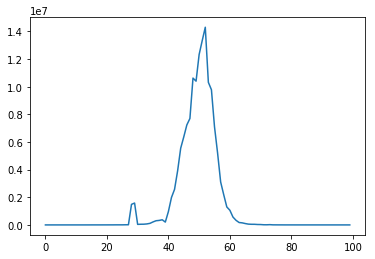

In [20]:
plt.plot(_)

## 2 dimensional

In [21]:
counts2d = df.count(binby=[df.pickup_longitude, df.pickup_latitude], shape=128)
print(counts2d.shape)

(128, 128)


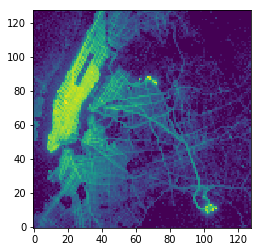

In [22]:
plt.imshow(np.log10(counts2d+1).T, origin='lower')

In [23]:
limits = df.limits([df.pickup_longitude, df.pickup_latitude], "98%")
limits

[array([-74.03799976, -73.774866  ]), array([40.6379567 , 40.81379327])]

CPU times: user 1.58 s, sys: 66.7 ms, total: 1.64 s
Wall time: 351 ms


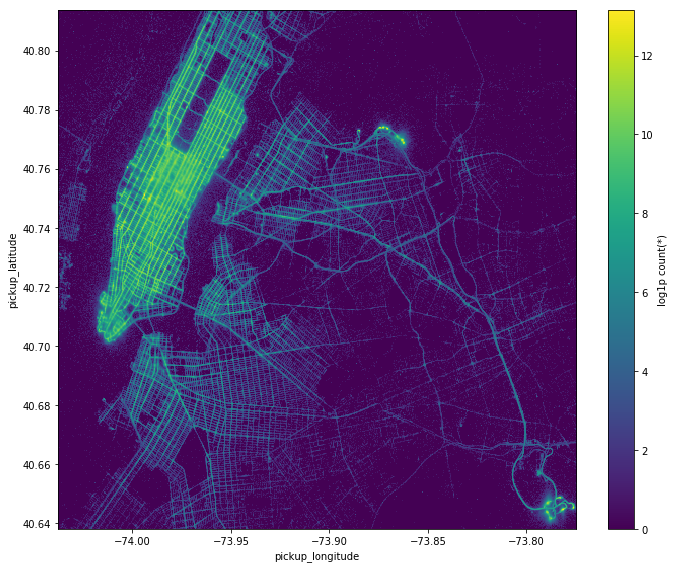

In [24]:
%%time
df.plot(df.pickup_longitude, df.pickup_latitude, f="log1p",
        limits=limits, figsize=(10,8), shape=512, colormap="viridis")

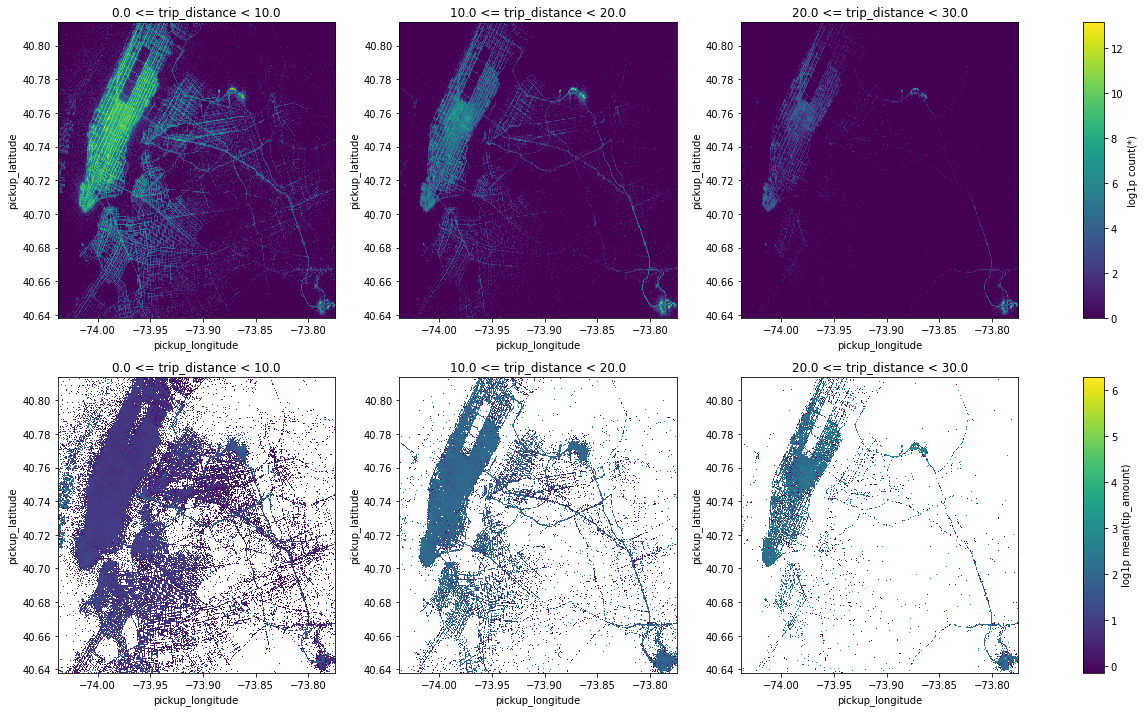

In [25]:
df.plot(df.pickup_longitude, df.pickup_latitude,
        z='trip_distance:0,30,3',
        what=[vaex.stat.count(), vaex.stat.mean(df.tip_amount)],
        visual=dict(column="z", row='what'),
        f="log1p",
        limits=limits, figsize=(16,10), shape=512, colormap="viridis")

## Where to pick up customers?

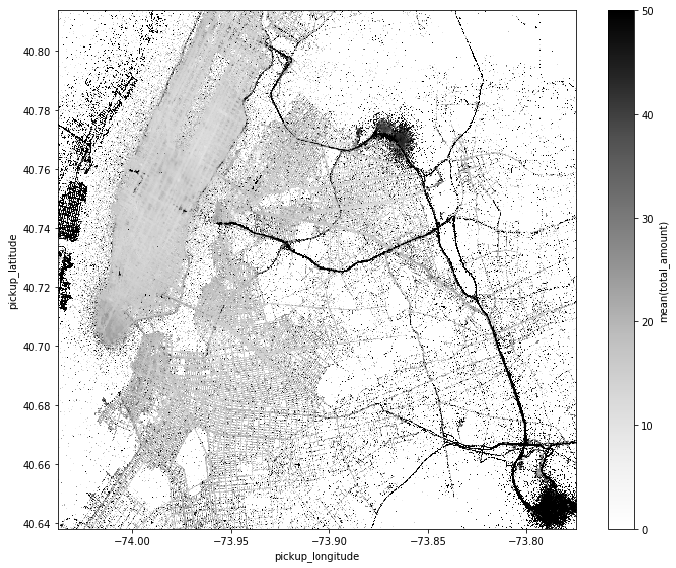

In [26]:
df.plot(df.pickup_longitude, df.pickup_latitude, what=vaex.stat.mean(df.total_amount),
        vmin=0, vmax=50, shape=512, figsize=(10,8), limits=limits, colormap="Greys")

In [27]:
df.trip_distance.minmax()

array([-4.08401244e+07,  1.98623014e+08])

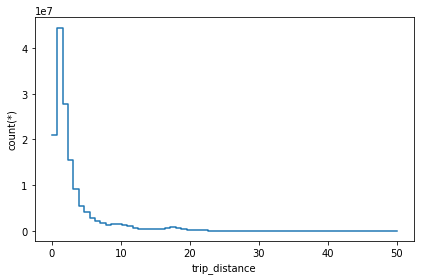

In [28]:
df.plot1d(df.trip_distance, limits=[0, 50])

In [29]:
# no memory copy! and not wasting 46 GB of memory
df_clean = df[(df.trip_distance > 0) & (df.trip_distance < 40)]

In [30]:
df_clean.total_amount/df_clean.trip_distance

<vaex.expression.Expression(expressions='(total_amount / trip_distance)')> instance at 0x6d561ac18 values=[10.723270440251572, 5.3939393939393945, 6.0, 9.6, 5.433333333333334 ... (total 145169109 values) ... 8.8, 4.4, 3.8947368421052637, 5.000000000000001, 16.754716981132077] 

In [31]:
df_clean['ratio'] = df_clean.total_amount / df_clean.trip_distance
df_clean.ratio

<vaex.expression.Expression(expressions='ratio')> instance at 0x6d55e39b0 values=[10.723270440251572, 5.3939393939393945, 6.0, 9.6, 5.433333333333334 ... (total 145169109 values) ... 8.8, 4.4, 3.8947368421052637, 5.000000000000001, 16.754716981132077] 

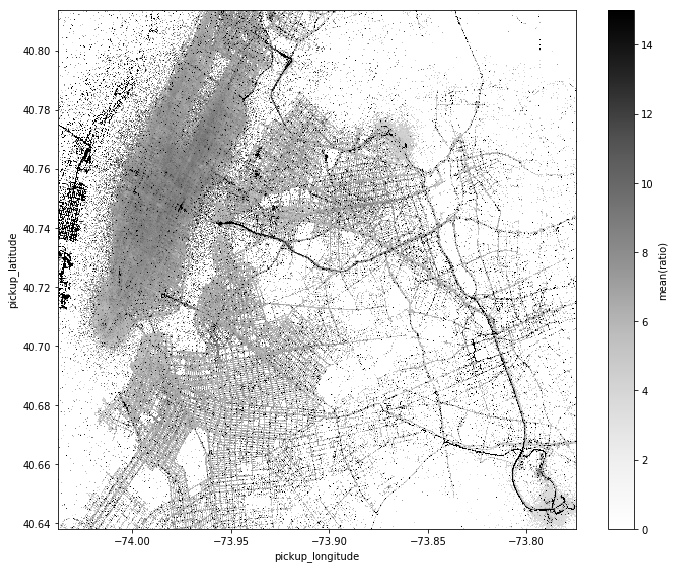

In [32]:
df_clean.plot(df_clean.pickup_longitude, df_clean.pickup_latitude,
         what=vaex.stat.mean(df_clean.ratio),
         vmin=0, vmax=15,
         shape=512, figsize=(10,8), limits=limits, colormap="Greys")

# Interactive

In [33]:
import vaex
import pylab as plt
df = vaex.open("/Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow")
limits = df.limits([df.pickup_longitude, df.pickup_latitude], "98%")

In [34]:
w = df.plot_widget(df.pickup_longitude, df.pickup_latitude, selection=[None, 'JFK', 'LaG'],
             controls_selection=True, f='log',
             shape=512, figsize=(10,8), limits=limits, colormap="afmhot")#, backend='ipyleaflet')

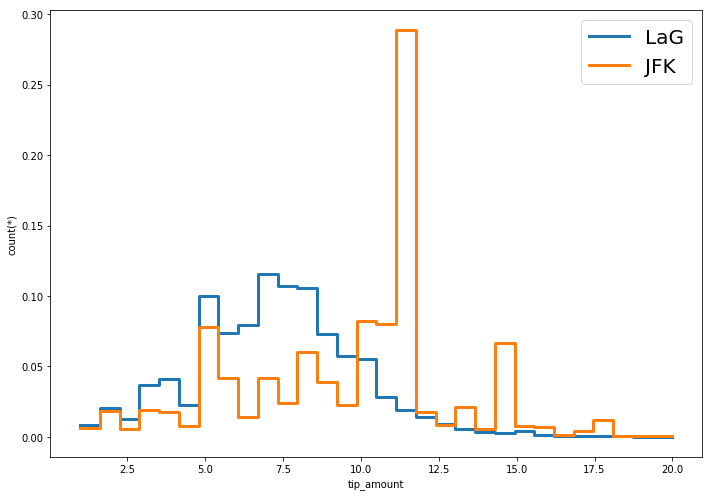

In [35]:
limits = [1, 20]
shape = 30
plt.figure(figsize=(10,7))
df.plot1d(df.tip_amount, selection='LaG', n=True, limits=limits, shape=shape, lw=3)
df.plot1d(df.tip_amount, selection='JFK', n=True, limits=limits, shape=shape, lw=3)
plt.legend(fontsize=20)

# Heavy calculations

In [36]:
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 6400

In [37]:
# distance Groningen - Paris (in kilometer)
arc_distance(53.1739086, 6.5990374, 48.8588376,2.2768492)

569.4741010237882

In [38]:
arc_distance_expression = arc_distance(df.pickup_longitude,
                                       df.pickup_latitude,
                                       df.dropoff_longitude,
                                       df.dropoff_latitude)

In [39]:
arc_distance_expression

<vaex.expression.Expression(expressions='((2 * arctan2(sqrt(((sin(((((dropoff_longitude - pickup_longitude) / 2) * 3.141592653589793) / 180)) ** 2) + ((cos(((pickup_longitude * 3.141592653589793) / 180)) * cos(((dropoff_longitude * 3.141592653589793) / 180))) * (sin(((((dropoff_latitude - pickup_latitude) / 2) * 3.141592653589793) / 180)) ** 2)))), sqrt((1 - ((sin(((((dropoff_longitude - pickup_longitude) / 2) * 3.141592653589793) / 180)) ** 2) + ((cos(((pickup_longitude * 3.141592653589793) / 180)) * cos(((dropoff_longitude * 3.141592653589793) / 180))) * (sin(((((dropoff_latitude - pickup_latitude) / 2) * 3.141592653589793) / 180)) ** 2))))))) * 6400)')> instance at 0x6d6583198 values=[2.134847189710858, 1.3436417836223224, 1.4496807895108483, 0.5646496959745897, 3.736681188096064 ... (total 146112989 values) ... 0.8502298378702033, 2.8873697620975967, 1.4188728381911406, 2.273223299270261, 0.7637761200287738] 

In [40]:
df['arc_distance'] = arc_distance(df.pickup_longitude,
                                  df.pickup_latitude,
                                  df.dropoff_longitude,
                                  df.dropoff_latitude)

In [41]:
df

In [42]:
%%time
df.sum(df.total_amount)

CPU times: user 922 ms, sys: 531 ms, total: 1.45 s
Wall time: 225 ms


array(2.3518708e+09)

In [43]:
%%time
df.sum(df.arc_distance)

CPU times: user 36.7 s, sys: 11.4 s, total: 48.2 s
Wall time: 10.6 s


array(4.20390224e+08)

In [44]:
df['arc_distance_jit'] = df.arc_distance.jit_numba()
# ds['arc_distance_jit'] = ds.arc_distance.jit_pythran()

In [45]:
%%time
df.sum(df.arc_distance_jit)

CPU times: user 16.7 s, sys: 302 ms, total: 17 s
Wall time: 2.64 s


array(4.20390224e+08)

In [ ]:
# if you got RAM to waste (I don't on this machine)
# TODO: optimize materialize
# ds.materialize(ds.arc_distance, inplace=True)

In [ ]:
# %%timeit -n1 -r3
# ds.sum(ds.arc_distance)

# Expression advantages
  * No information loss
  * Optimization (jit: numba/pythran)
  * Derivatives (error/uncertainty propagation)
  * No memory waste, only calculate what is needed  
  * Do 'remote' calculations


# Remote datasets

In [ ]:
import vaex
import numpy as np

In [ ]:
df_remote = vaex.open('ws://gaia:10000/nyc_taxi_all')
# ds_remote = vaex.open('ws://localhost:9000/nyc_taxi_all')
df_remote

In [ ]:
df_remote.total_amount / 100

In [ ]:
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 6400

In [ ]:
df_remote['arc_distance'] = arc_distance(df_remote.pickup_longitude,
                                         df_remote.pickup_latitude,
                                         df_remote.dropoff_longitude,
                                         df_remote.dropoff_latitude)

In [ ]:
df_remote.arc_distance

In [ ]:
df_remote['arc_distance_jit'] = df_remote.arc_distance.jit_numba()

In [ ]:
df_remote.arc_distance_jit

In [ ]:
%%time
df_remote.mean('arc_distance', progress=True)

In [ ]:
%%time
df_remote.mean('arc_distance_jit', progress=True)

In [ ]:
limits = df_remote.limits([df_remote.pickup_longitude, df_remote.pickup_latitude], "98%")

In [ ]:
# ds_remote.plot_widget(ds_remote.pickup_longitude, ds_remote.pickup_latitude, backend='ipyleaflet', f='log', shape=400)

In [ ]:
df_remote.plot_widget(df_remote.pickup_longitude, df_remote.pickup_latitude,
                     selection=[None, 'JFK', 'LaG'],
                     controls_selection=True, f='log',
                     shape=512, figsize=(10,8), limits=limits, colormap="afmhot")

In [ ]:
import matplotlib.pylab as plt

In [ ]:
limits = [1, 20]
shape = 30
plt.figure(figsize=(10,7))
df_remote.plot1d(df_remote.tip_amount, selection='LaG', n=True, limits=limits, shape=shape, lw=3)
df_remote.plot1d(df_remote.tip_amount, selection='JFK', n=True, limits=limits, shape=shape, lw=3)
plt.legend(fontsize=20)